# Exercise 1: A Fully Linear Model

*This is the companion notebook to Exercise 1 in Hogg, Price-Whelan & Leistedt (2020).*

In [1]:
# Standard library packages
import os
import sys

# Third-party packages
import astropy.table as at
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Set up a deterministic random number generator:
#  Note: this requires numpy>=1.17
rnd = np.random.Generator(np.random.PCG64(seed=42))

For this exercise, we will use a quadratic polynomial as our parametric model to both generate some simulated data, and to represent the data when inferring the parameters of the model:
$$
f(x \,;\, \alpha, \beta, \gamma) = \alpha\, x^2 + \beta \, x + \gamma
$$
where $(\alpha, \beta, \gamma)$ are the (linear) coefficients of the quadratic polynomial.

To start off, let's define true parameter values, which we will use to generate the simulated data:

In [2]:
true_pars = (3.21, 2.44, 14.82)
K = len(true_pars)  # number of parameters

We can now generate our simulated data and store it as an astropy `Table` object for easy writing and printing to latex (for including in the companion paper). We round the values to make it more concise when including the data in the companion article. The ranges used below in the random number generators were chosen arbitrarily.

In [3]:
N = 4  # number of data points

t = at.Table()
t['x'] = np.round(np.sort(rnd.uniform(-5, 5, size=N)), 
                  decimals=1)
sigma_y = np.round(np.sort(rnd.uniform(0.5, 4, size=N)), 
                   decimals=1)
t['y'] = np.round(rnd.normal(np.poly1d(true_pars)(t['x']), sigma_y),
                  decimals=1)
t['sigma_y'] = sigma_y

t.write('data1.csv', overwrite=True)  # to archive
t.write(sys.stdout, format='ascii.latex')  # to include in Latex

\begin{table}
\begin{tabular}{ccc}
x & y & sigma_y \\
-0.6 & 14.5 & 0.8 \\
2.0 & 29.8 & 3.2 \\
2.7 & 47.7 & 3.3 \\
3.6 & 68.2 & 3.9 \\
\end{tabular}
\end{table}


Next, we set up the 2D arrays to represent the various matrices we need to solve the problem. First, the (inverse) covariance tensor of the data, $\mathrm{C}^{-1}$. Here, we assume the data are independent, so this matrix is diagonal:

In [4]:
Cinv = np.diag(1 / t['sigma_y']**2)

Next, we set up the design matrix $\mathrm{M}$. For this, we use the `numpy` convenience function `numpy.vander`:

In [5]:
M = np.vander(t['x'], K)
M

array([[ 0.36, -0.6 ,  1.  ],
       [ 4.  ,  2.  ,  1.  ],
       [ 7.29,  2.7 ,  1.  ],
       [12.96,  3.6 ,  1.  ]])

Finally, we have to create numpy arrays to specify the parameters of our (Gaussian) prior pdf. Here, we also assume that the prior pdf is a product of independent Gaussians, so the (inverse) variance tensor is also diagonal. The values used here are specified in the companion paper (under Exercise 1):

In [6]:
mu = np.array([1, 3, 9])

sigmas = np.array([5, 2, 8])
Linv = np.diag(1 / sigmas**2)

We now have all of the objects we need to compute the MAP parameter vector and the associated variance tensor of the posterior (Gaussian) pdf. Following the nomenclature and expressions in the companion paper,

In [7]:
Ainv = Linv + M.T @ Cinv @ M
A = np.linalg.inv(Ainv)
a = A @ (Linv @ mu + M.T @ Cinv @ t['y'])
a

array([ 3.61320828,  1.98196203, 14.2581612 ])

We now have the mean and variance tensor of the posterior pdf, so we can directly generate posterior samples of our parameters using `numpy.random.multivariate_normal`:

In [8]:
samples = rnd.multivariate_normal(a, A, size=4096)

To complete the exercise, we must now plot the data, the MAP model, and the 68% credible region:

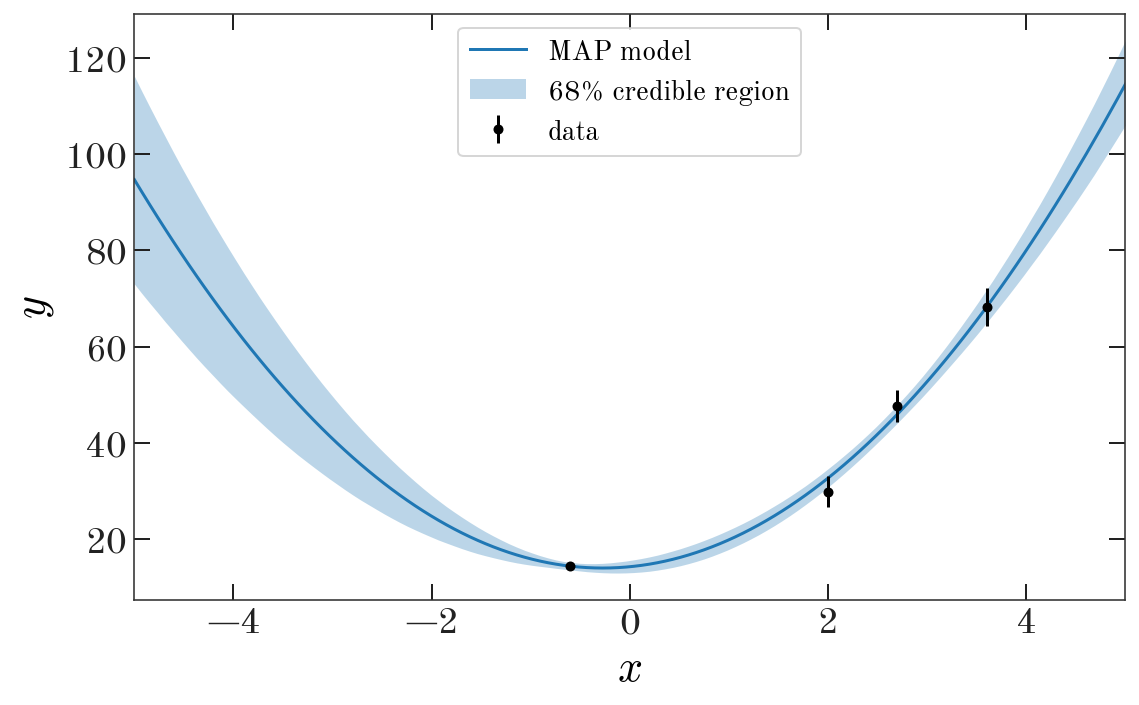

In [9]:
plt.figure(figsize=(8, 5))

plt.errorbar(t['x'], t['y'], t['sigma_y'], 
             ls='none', marker='o', zorder=10,
             label='data')

xpred = np.linspace(-5, 5, 128)
plt.plot(xpred, a[0] * xpred**2 + a[1] * xpred + a[2], 
         marker='', color='tab:blue', zorder=1,
         label='MAP model')

ypred = (samples[:, 0][None] * xpred[:, None]**2 + 
         samples[:, 1][None] * xpred[:, None] + 
         samples[:, 2][None])
yfill = np.percentile(ypred, q=[16, 84], axis=1)
plt.fill_between(xpred, yfill[0], yfill[1], 
                 zorder=0, color='tab:blue', alpha=0.3, lw=0,
                 label='68% credible region')

plt.xlim(-5, 5)
# plt.ylim(-20, 20)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='upper center', fontsize=14)

plt.tight_layout()
plt.savefig('../paper/exercise1.pdf')

As a final visualization, we can make a [`corner`](https://corner.readthedocs.io/en/latest/) plot of the samples to visualize projections of the posterior samples we generated:

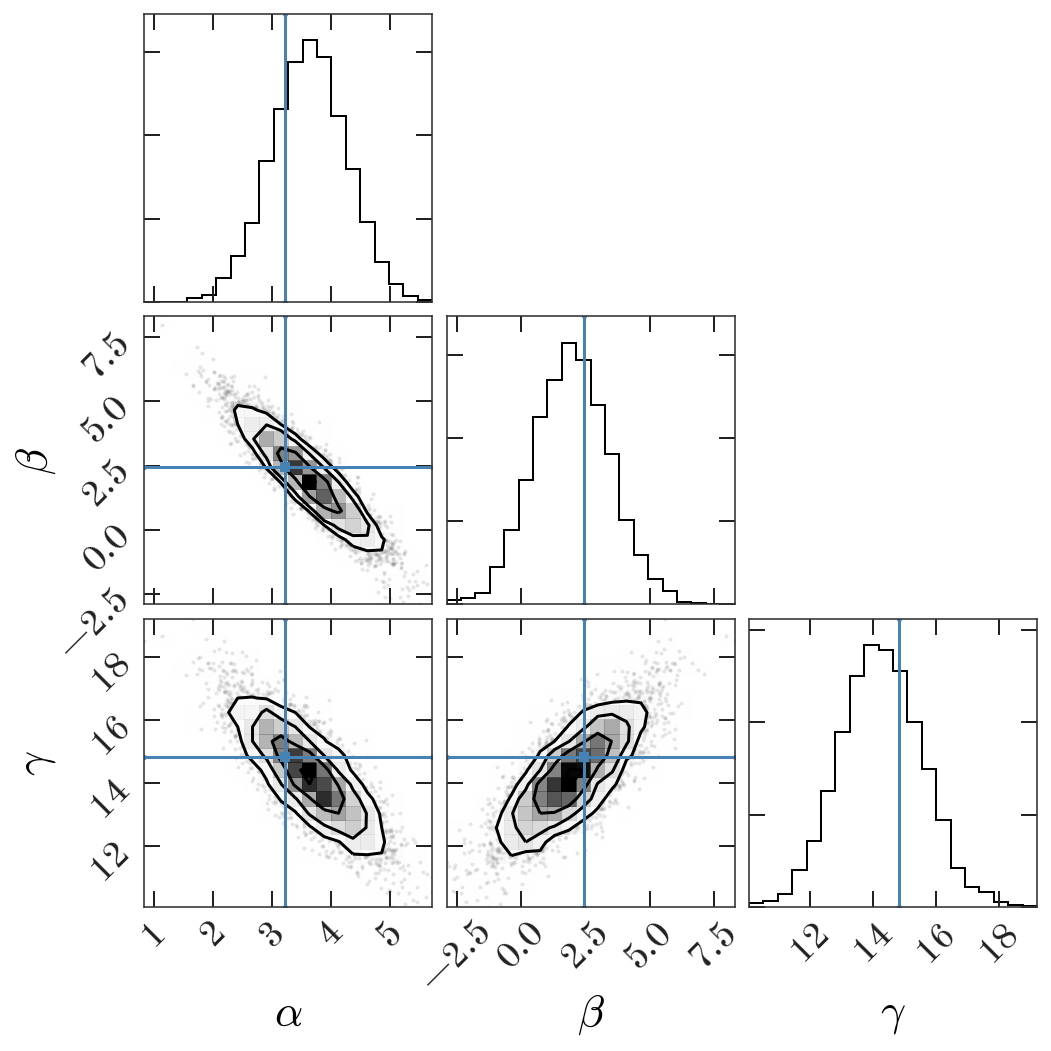

In [10]:
_ = corner.corner(samples, 
                  truths=true_pars, 
                  labels=[r'$\alpha$', r'$\beta$', r'$\gamma$'])